## Plot the generated daily soil and runoff cation concentrations

In [1]:
import os
import xarray as xr
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shared_read_HBR import *
from matplotlib import rcParams

site = 'UC_Davis'

rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 18

In [2]:
if site == 'HBR_1':
    flist_1 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                            'ERW_HBR_1_ICB20TRCNPRDCTCBC', 'run', 
                            f'ERW_HBR_1_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
               for yy in range(1980, 1998)]
    flist_2 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                            'ERW_20240310_HBR_1_ICB20TRCNPRDCTCBC', 'run', 
                            f'ERW_20240310_HBR_1_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
               for yy in range(1998, 2014)]
else:
    flist_1 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                            'ERW_UC_Davis_ICB20TRCNPRDCTCBC', 'run', 
                            f'ERW_UC_Davis_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
               for yy in range(1980, 2018)]
    flist_2 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                            'ERW_20231110_UC_Davis_ICB20TRCNPRDCTCBC', 'run', 
                            f'ERW_20231110_UC_Davis_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
               for yy in range(2018, 2023)]

hr = xr.open_mfdataset(flist_1 + flist_2)
tvec = pd.DatetimeIndex([pd.Timestamp(year=t.year, month=t.month, day=t.day) for t in hr['time'].values])

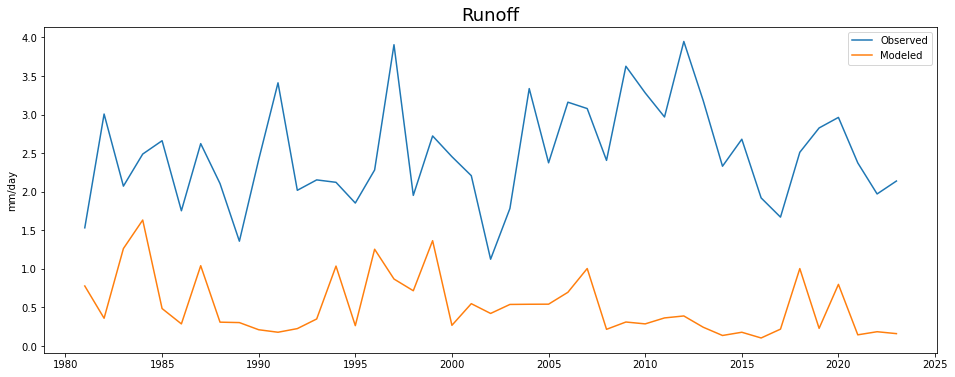

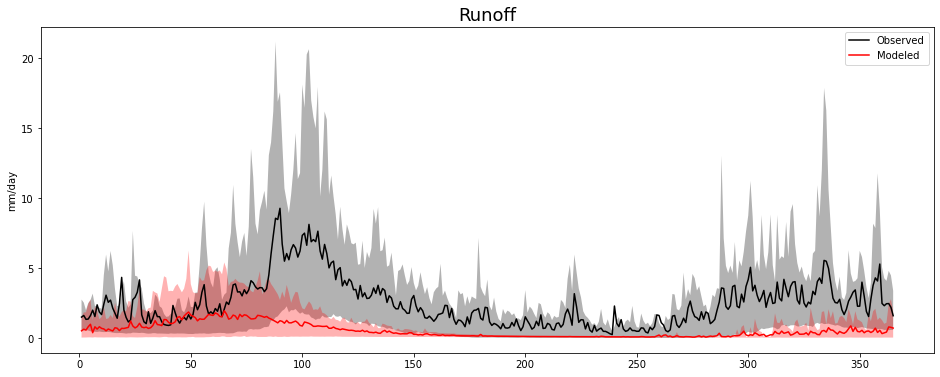

In [3]:
runoff_obs = read_runoff() # mm/day
runoff_sim = pd.Series(
    hr['QRUNOFF'][:, 0] * 86400, 
    index = tvec[:]
)

common_index = runoff_obs.index.intersection(runoff_sim.index)

# annual time series
fig, ax = plt.subplots(figsize = (16,6))
obs_ann = runoff_obs.loc[common_index].resample('1Y').mean()
sim_ann = runoff_sim.loc[common_index].resample('1Y').mean()
ax.plot(obs_ann.index, obs_ann, label = 'Observed')
ax.plot(sim_ann.index, sim_ann, label = 'Modeled')
ax.set_xlabel('')
ax.set_ylabel('mm/day')
ax.legend()
ax.set_title('Runoff')
plt.savefig('./temp/hbr_runoff_annual.png', dpi = 600., bbox_inches = 'tight')


# daily annual cycle
fig, ax = plt.subplots(figsize = (16,6))

obs_box = runoff_obs.loc[common_index].values.reshape(-1, 365)
ax.plot(range(1, 366), obs_box.mean(axis = 0), '-k', label = 'Observed')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(obs_box, 10, axis = 0),
    np.nanpercentile(obs_box, 90, axis = 0), 
    fc = 'k', alpha = 0.3
)

sim_box = runoff_sim.loc[common_index].values.reshape(-1, 365)
ax.plot(range(1, 366), sim_box.mean(axis = 0), '-r', label = 'Modeled')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(sim_box, 10, axis = 0),
    np.nanpercentile(sim_box, 90, axis = 0), 
    fc = 'r', alpha = 0.3
)

ax.set_xlabel('')
ax.set_ylabel('mm/day')
ax.legend()
ax.set_title('Runoff')
plt.savefig('./temp/hbr_runoff.png', dpi = 600., bbox_inches = 'tight')

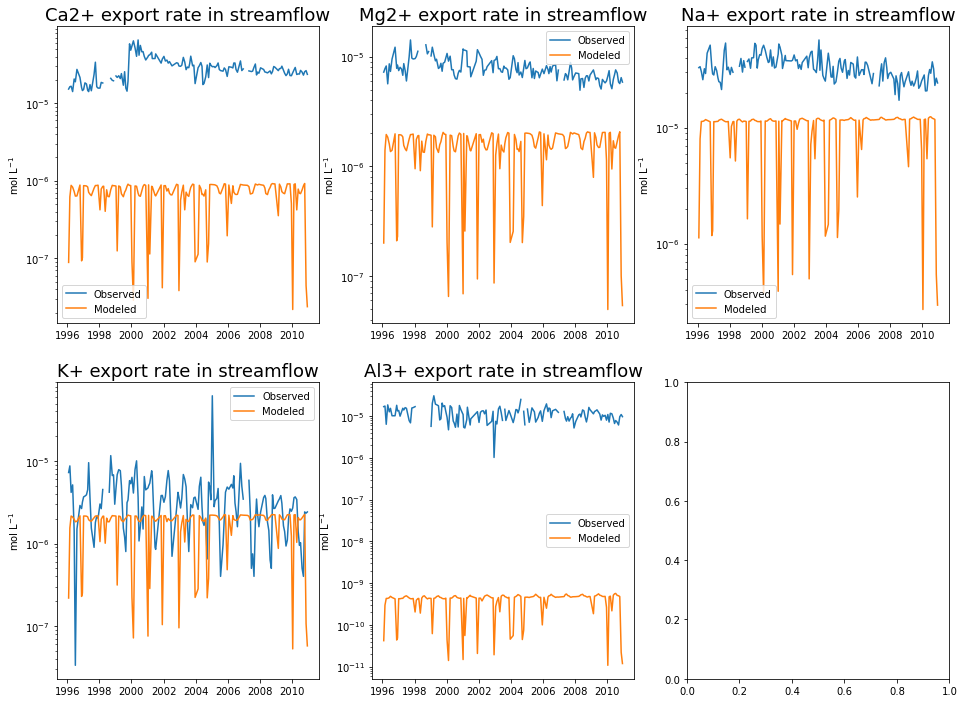

In [4]:
# cation_export_obs = convert_streamChem(read_streamChem())

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# The underestimation is definitely because I didn't account for all the soil layers

cation_export_obs = read_streamChem() * 1e-6 # umol/L -> mol/L


LEVGRND = np.array([0.007100635, 0.027925, 0.06225858, 0.1188651, 0.2121934,
                    0.3660658, 0.6197585, 1.038027, 1.727635, 2.864607, 4.739157,
                    7.829766, 12.92532, 21.32647, 35.17762])
LEVGRND_I = np.append(np.insert(
    (LEVGRND[1:] + LEVGRND[:-1])*0.5, 0, 0
), LEVGRND[-1] + 0.5 * (LEVGRND[-1] - LEVGRND[-2]))
THICKNESS = np.diff(LEVGRND_I)

top_layer_water = np.matmul(hr['H2OSOI'][:, :6, 0].values, (THICKNESS[:6].reshape(-1, 1)))
all_water = np.matmul(hr['H2OSOI'][:, :, 0].values, THICKNESS.reshape(-1,1))

cation_export_sim = pd.DataFrame(
    (hr['cation_leached'][:, :, 0] + hr['cation_runoff'][:, :, 0]) / \
    ((hr['QRUNOFF'] + hr['QDRAI'])[:,0].values.reshape(-1,1) * top_layer_water / all_water),
    index = tvec, columns = ['Ca2+','Mg2+','Na+','K+','Al3+'])

cation_export_sim = cation_export_sim.loc[
    cation_export_obs.index.intersection(cation_export_sim.index), :]

cation_export_obs = cation_export_obs.loc[
    (cation_export_obs.index.year >= 1996) & 
    (cation_export_obs.index.year <= 2010)]
cation_export_sim = cation_export_sim.loc[
    (cation_export_sim.index.year >= 1996) & 
    (cation_export_sim.index.year <= 2010), :]

fig, axes = plt.subplots(2, 3, figsize = (16, 12))
for i, (obs_ca, sim_ca, mass_ca) in enumerate(
    zip(['Ca2', 'Mg2', 'Na', 'K', 'Alt'],
        ['Ca2+','Mg2+','Na+','K+','Al3+'],
        [40, 24, 23, 29, 27])
):
    ax = axes.flat[i]

    ax.plot(cation_export_obs.index, cation_export_obs[obs_ca], label = 'Observed')
    ax.plot(cation_export_sim.index, cation_export_sim[sim_ca] / mass_ca, label = 'Modeled')

    ax.set_xlabel('')
    ax.set_ylabel('mol L$^{-1}$')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'{sim_ca} export rate in streamflow')
plt.savefig('./temp/hbr_cation_export.png', dpi = 600., bbox_inches = 'tight')

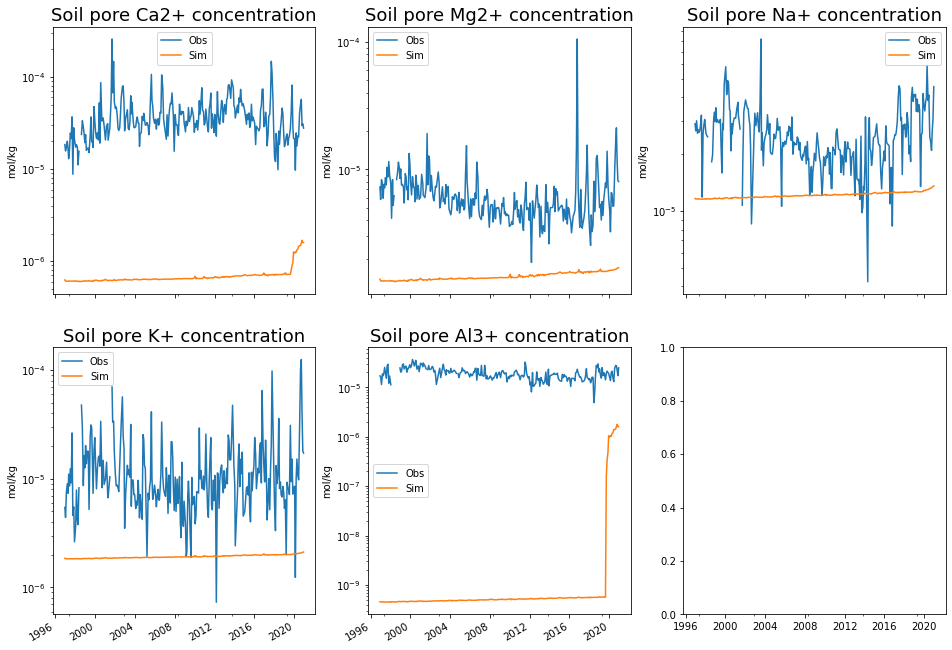

In [5]:
soil_pore_obs = read_lysimeter()

# calcium: convert from g m-3 soil to mol/kg porewater
soil_pore_sim = {}
for i, (cation, mass_ca) in \
    enumerate(zip(['Ca2+','Mg2+','Na+','K+','Al3+'], 
                  [40, 24, 23, 29, 27])):
    soil_pore_sim[cation] = pd.Series( 
        ((hr[f'cation_vr_{i+1}'][:,:6,0] / hr['H2OSOI'][:,:6,0] / mass_ca / 1000) *
        hr['levgrnd'].values[:6].reshape(1,-1)).sum(axis = 1) / hr['levgrnd'].values[:6].sum(), 
        index = tvec)
soil_pore_sim = pd.DataFrame(soil_pore_sim)
soil_pore_sim = soil_pore_sim.loc[
    soil_pore_sim.index.intersection(soil_pore_obs.index)]


fig, axes = plt.subplots(2, 3, figsize = (16, 12), sharex = True)
for i, (obs_ca, sim_ca) in enumerate(
    zip(['Ca2+', 'Mg2+', 'Na+', 'K+', 'Alt'],
        ['Ca2+','Mg2+','Na+','K+','Al3+'])
):
    ax = axes.flat[i]
    soil_pore_obs[obs_ca].plot(ax = ax, label = 'Obs')
    soil_pore_sim[sim_ca].plot(ax = ax, label = 'Sim')
    ax.set_xlabel('')
    ax.set_ylabel('mol/kg')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'Soil pore {sim_ca} concentration')
fig.savefig('./temp/hbr_soil_pore_water.png', dpi = 600., bbox_inches = 'tight')

In [6]:
# Calculate bicarbonate alkalinity from soil pH
# (1) pre-treatment (pre-2019: bicarbonate alkalinity)
# (2) during-treatment (2019-autumn 2020)
# (3) post-treatment (winter 2020-2021)

zsoi = np.insert((hr['levgrnd'].values[:-1] + hr['levgrnd'].values[1:]) / 2, 0, 0)
zsoi = np.insert(zsoi, -1, hr['levgrnd'].values[-1] + 
                0.5 * (hr['levgrnd'].values[-1] - hr['levgrnd'].values[-2]))
thickness = np.diff(zsoi)

alkalinity = np.zeros([len(hr['time']), 2])

for i, mixing_depth in enumerate([0.15, 0.3]):
    weight = np.where(zsoi[:-1] < mixing_depth, np.minimum(thickness, mixing_depth - zsoi[:-1]), 0)
    # mol L-1 => normalized to CaCO3 weight to multiply by 100
    hco3 = 10**(-7.8136)*360*1e-6/10**(-hr['soil_pH'].values[:,:,0]) * 100
    alkalinity[:,i] = np.nansum(hco3 * weight.reshape(1, -1), axis = 1) / np.sum(weight)

Text(0, 0.5, 'bicarbonate alkalinity (g/L)')

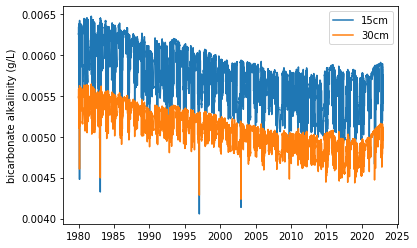

In [7]:
plt.plot(tvec, alkalinity)
plt.legend(['15cm', '30cm'])
plt.ylabel('bicarbonate alkalinity (g/L)')

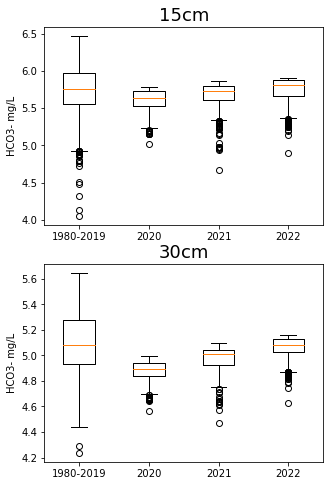

In [8]:
fig, axes = plt.subplots(2, 1, figsize = (5, 8))
for i, ax in enumerate(axes.flat):
    ax.boxplot([alkalinity[tvec.year < 2020, i] * 1000, 
                alkalinity[tvec.year == 2020, i] * 1000, 
                alkalinity[tvec.year == 2021, i] * 1000, 
                alkalinity[tvec.year == 2022, i] * 1000],
               positions = [0,1,2,3])
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['1980-2019','2020','2021','2022'])
    ax.set_ylabel('HCO3- mg/L')
    if i == 0:
        ax.set_title('15cm')
    else:
        ax.set_title('30cm')

In [9]:
ax.boxplot?

Signature:
ax.boxplot(
    x,
    notch=None,
    sym=None,
    vert=None,
    whis=None,
    positions=None,
    widths=None,
    patch_artist=None,
    bootstrap=None,
    usermedians=None,
    conf_intervals=None,
    meanline=None,
    showmeans=None,
    showcaps=None,
    showbox=None,
    showfliers=None,
    boxprops=None,
    labels=None,
    flierprops=None,
    medianprops=None,
    meanprops=None,
    capprops=None,
    whiskerprops=None,
    manage_ticks=True,
    autorange=False,
    zorder=None,
    *,
    data=None,
)
Docstring:
Draw a box and whisker plot.

The box extends from the first quartile (Q1) to the third
quartile (Q3) of the data, with a line at the median.  The
whiskers extend from the box by 1.5x the inter-quartile range
(IQR).  Flier points are those past the end of the whiskers.
See https://en.wikipedia.org/wiki/Box_plot for reference.

.. code-block:: none

          Q1-1.5IQR   Q1   median  Q3   Q3+1.5IQR
                       |-----:-----|
       o   

In [10]:
hr.close()